In [11]:
import numpy as np
import pandas as pd
from metrics import *
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
import seaborn as sns
import plotly_express as px
from scipy.spatial.distance import cdist
from kmeans import *
from fuzzy_c_means import *
import plotly.graph_objects as go

# Iris dataset

In [3]:
# load the iris dataset
iris_data = load_iris() 
df_data = pd.DataFrame(data= np.c_[iris_data['data'], iris_data['target']],
                     columns= iris_data['feature_names'] + ['target'])
# drop target
df_data = df_data.drop(columns=['target'])

## K-means clustering

In [3]:
centroids,clusters = kmeans_clustering(df_data,3)

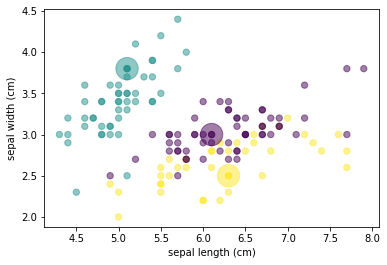

In [5]:
# plot the results
plot_kmeans(df_data, 3, centroids.values, clusters)

## Fuzzy c means clustering

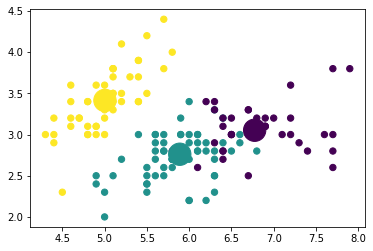

In [7]:
centroids, membership_matrix = fuzzy_clustering(df_data, 3, 2)
plot_fuzzy_cmeans(df_data.values, 3, centroids, membership_matrix)


## Mountain clustering

In [50]:
def mountain(data:pd.DataFrame, grid_size,std,destr_param,n_clusters,max_iter=1000,distance='euclidean'):
    n = data.shape[0]
    m = data.shape[1]

    grid = np.linspace(0,1,grid_size)
    centers = np.array(np.meshgrid(*[grid]*m)).T.reshape(-1,m)

    grid_n = centers.shape[0]
    mountain_heights = np.arange(1,grid_n+1)
    all_heights = []

    criteria = True
    n_iter = 0
    initial_height = np.Inf
    while criteria:
        n_iter += 1

        for i in range(grid_n): 
            if mountain_heights[i] != 0:
                accum = 0
                for j in range(n):
                    accum += np.exp(-similarity(centers[i],data[j,:],'euclidean')**2 / (2*std**2))
                mountain_heights[i] = accum

        max_center = centers[np.argmax(mountain_heights)]

        for i in range(grid_n):
            if mountain_heights[i] != 0:
                centers[i] = centers[i] - max_center * np.exp(-similarity(centers[i],max_center,'euclidean')**2 / (2*destr_param**2)) 
                if np.all(centers[i] == 0):
                    mountain_heights[i] = 0
        all_heights.append(mountain_heights.copy())

        if max_iter == n_iter:
            criteria = False
        
        if n_clusters == -1:
            if np.sum(mountain_heights!=0) == initial_height or np.sum(mountain_heights!=0) == 2:
                criteria = False
            else:
                initial_height = np.sum(mountain_heights!=0)
        else:
            if np.sum(mountain_heights!=0) == n_clusters:
                criteria = False
    
    clusters = np.zeros(n)
    for i in range(n):
        min_distance = np.Inf
        for j in range(grid_n):
            distance = similarity(data[i,:],centers[j],distance)
            if distance < min_distance:
                min_distance = distance
                clusters[i] = j
    all_heights = all_heights.reshape(n_iter,grid_n)
    return all_heights,mountain_heights,centers,clusters

In [51]:
# unsupervised learning, mountain clustering
heights_all, heights, prototypes, clusters = mountain(df_data.values, 1, 0.2, 0.2, -1)

ValueError: Unknown metric 6.345076831686122